## Deep Learning and Transfer Learning

Different ways Transfer Learning can be adopted, insipration taken from [article](https://towardsdatascience.com/deep-learning-and-transfer-learning-31c6394b10c5)
- Transfer learning using the entire (except top layer) pre-trained model
- Transfer learning using a specific segment of the pre-trained model
- Transfer learning by loading new weights into a pre-trained model
- Transfer learning by upsampling image shape to fit the inputs requirements of a pre-trained model

In [49]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
%matplotlib inline

In [7]:
data = tf.keras.datasets.cifar10

In [10]:
(train_images, train_labels), (test_images, test_labels) = data.load_data()

In [11]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


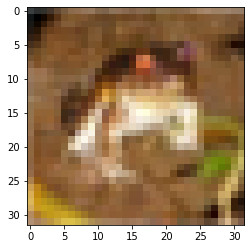

In [63]:
plt.imshow(train_images[0])

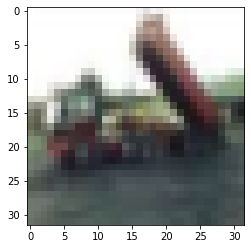

In [64]:
plt.imshow(train_images[2])

In [13]:
print('Image Classes:' + str([x[0] for x in train_labels[0:5]]))

print('Image Labels: ' + str([classes[x[0]] for x in train_labels[0:5]]))

Image Classes:[6, 9, 9, 4, 1]
Image Labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


In [26]:
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### 1. Transfer learning using the entire (except top layer) pre-trained model

The first technique involves loading a pre-trained model, using its weights as the first sequential layer in your model and adding your own custom layers (ie. process typically called “Fine-tuning”) to classify the CIFAR-10 images.

In [36]:
# 1) instantiate the pre-trained ResNet-50 model
# 2) Setting the “include_top” parameter to “False” will essentially remove the last (ie. top) 
#    fully connected prediction (softmax) dense layer.
# 3) first layer in our model we set the input_shape to (32, 32, 3) which is the shape of our CIFAR-10 images
K.clear_session()
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=train_labels.shape[1])

In [46]:
# K.clear_session() is useful when you're creating multiple models in succession, 
# such as during hyperparameter search or cross-validation

In [37]:
# Since the whole purpose of transfer learning is to use the pre-trained model’s knowledge 
# (ie. pre-trained weights) in our model, we’ll set the “trainable” parameter to False
base_model.trainable = False
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000021148C07588> False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000021148BB54C8> False
<keras.layers.convolutional.Conv2D object at 0x0000021148B96288> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000021148BC2F88> False
<keras.layers.core.activation.Activation object at 0x000002113F364E08> False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000021148BFA988> False
<keras.layers.pooling.MaxPooling2D object at 0x0000021148C03FC8> False
<keras.layers.convolutional.Conv2D object at 0x000002113E4DB688> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002113E4D3E48> False
<keras.layers.core.activation.Activation object at 0x000002113F09D788> False
<keras.layers.convolutional.Conv2D object at 0x000002113F067A48> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002113F064D08> False
<keras.layers.core.activ

In [38]:
pre_trained_model = base_model.output 
flat = tf.keras.layers.Flatten()(pre_trained_model)
dense1 = tf.keras.layers.Dense(1024, activation='relu')(flat)
dense2 = tf.keras.layers.Dense(512, activation='relu')(dense1)
predictions = tf.keras.layers.Dense(10, activation='softmax')(dense2)

In [39]:
model_1 = Model(inputs = base_model.input, outputs = predictions, name="cifar10_model")

In [40]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model_1.summary()

Model: "cifar10_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                      

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 2, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 1, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 1, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 1, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

### 2. Transfer learning using a specific segment of the pre-trained model

When building convolutional networks the earlier convolution layers learn very generalizable features (ie. vertical/horizontal lines, global shapes, etc.) whereas the latter convolutional layers learn very specific features. The latter layers would be less generalizable to images the model hasn’t seen. Therefore, it is sometimes better to use only the first few convolution layers from the pre-trained model and then add your own fine-tuning layers to learn features specific to your training images.

In [42]:
K.clear_session()
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=train_labels.shape[1])

In [43]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 2, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 2, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 2, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 1, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 1, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 1, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [44]:
# make cut at layer named “conv3_block1_3_conv”
# we obtain the specific layer using the get_layer() function and set its output to the last_output variable.
# Last_output becomes the first layer in our fine_tuning model and its output gets passed into the flattening layer.

K.clear_session()

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=train_labels.shape[1])

base_model.trainable = False

# last_layer = base_model.get_layer('conv3_block1_3_conv')
# last_output = last_layer.output
last_output = base_model.get_layer('conv3_block1_3_conv').output

flat = tf.keras.layers.Flatten()(last_output) # add output layer from RestNet50 to the dense layers

dense1 = tf.keras.layers.Dense(1024, activation='relu')(flat)

dense2 = tf.keras.layers.Dense(512, activation='relu')(dense1)

predictions = tf.keras.layers.Dense(10, activation='softmax')(dense2)

model_2 = Model(inputs = base_model.input, outputs = predictions, name="cifar10_model")

model_2.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model_2.summary()

Model: "cifar10_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                      

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 8, 64)    256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 8, 64)    0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 8, 256)    16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv2_block3_3_conv[0][0]']    
 ization) 

### 3. Transfer learning by loading new weights into the pre-trained model

There will be times when you would want to unfreeze some of the layers in the pre-trained transfer model (ie. ResNet or Inception) to retrain those “unfrozen” layers using your training images. If you ever wanted to reuse this new version of your fine-tuning model with some retrained ResNet or Inception layers you would need to upload these weights into a model in the future. In this section, it is discussed how to load custom weights stored in a “h5” file into the pre-trained model’s architecture.

In [ ]:
# 1) To obtain the weights specific to the model'S architecture
# 2) To instantiate the pre-trained model, set "weights" parameter to None. 
# 3) Set the “by_name” parameter to True as this will load the weights according to the name of each layer

# This procedure only loads the weights for the pre-trained model (ie. Inception, ResNet, VGG, etc.) 
# it does not load the weights for the entire fine-tuning model.

# Note - weights do not possess the top (ie. prediction) layer. Notice the “notop.h5” in the file label

K.clear_session()
!wget --no-check-certificate \
https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 \
-O /tmp/resnet_50_weights_tf_dim_ordering_tf_kernels_notop.h5
local_weights_file = '/tmp/resnet_50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = ResNet50(weights=None, input_shape=(32, 32, 3), include_top=False, classes=train_labels.shape[1])
base_model.load_weights(local_weights_file, by_name=True)

###  4. Transfer learning by upsampling image shape to fit inputs requirements of the pre-trained model

Some models require you to adjust the input size of your data prior to passing the data. For example, if you were to utilize the first transfer learning approached we discussed above, but this time using the Inception_V3 model, you would be presented with the error seen below. This is due to the shape of CIFAR-10 images being 32x32x3 whereas the Inception_V3 model requires the images to be at least 75x75, regardless of the number of channels. On the other hand, ResNet has an optimal shape but it does not require your input shape to be a specific size.

In [ ]:
# There are various techniques used to perform this operation but Keras has a “Upsamplign2D” 
# class which simply duplicates the pixels to the specified shape

K.clear_session()

base_model = InceptionV3(include_top=False, weights='imagenet',  input_shape=(128, 128, 3), classes=train_labels.shape[1])

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(32, 32, 3)) 

upsamp1 = tf.keras.layers.UpSampling2D((2,2))(inputs)

upsamp2 = tf.keras.layers.UpSampling2D((2,2))(upsamp1)

pre_trained_model = base_model(upsamp2)

flat = tf.keras.layers.Flatten()(pre_trained_model)

dense1 = tf.keras.layers.Dense(1024, activation='relu')(flat)

dense2 = tf.keras.layers.Dense(512, activation='relu')(dense1)

drop1 = tf.keras.layers.Dropout(0.3)(dense2)

dense3 = tf.keras.layers.Dense(128, activation='relu')(drop1)

predictions = tf.keras.layers.Dense(10, activation='softmax')(dense3)

model_4 = Model(inputs = inputs, outputs = predictions)

model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])                                                       